In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, LogitLocator, NullFormatter
from jackknife import *
from scipy.optimize import curve_fit, root_scalar
from scipy.integrate import quad, quad_vec, dblquad
from scipy.special import gamma, hyp2f1
from corr_fits import *
from spectral_density import *
import mpmath

mpmath.mp.dps = 15
plt.style.use('my_style.mplstyle')
#plt.rcParams.update({'font.size': 16})
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

kernels_mellin = {
    "None": lambda s, w, sigma: np.sqrt(2. * np.pi) * u_s(s, w),
    "Gaussian": lambda s, w, sigma: np.exp(-w**2.0/(4.0 * sigma ** 2.0)) * complex(mpmath.pcfd(-0.5 - s * 1.0j, - w/sigma) *\
                                                                                      mpmath.gamma(0.5 + s * 1.0j)) * u_s(s, sigma),
    "Tikhonov": lambda s, w, a: np.sqrt(2. * np.pi) * u_s(s, w) * np.abs(gamma(0.5 + s * 1.0j))**2.0 / (np.abs(gamma(0.5 + s * 1.0j))**2.0 + a),
    "Breit-Wigner": lambda s, w, sigma: -np.sqrt(2.*np.pi) * u_s(s, np.sqrt(w**2.0 + sigma**2.0)) * complex(mpmath.sin((-0.5+s*1.0j)*mpmath.acos(-w/mpmath.sqrt(w**2.0 + sigma**2.0)))/\
                                        mpmath.sin((0.5+s*1.0j)*np.pi))
}

def u_s(s:float, w:float) -> complex:
    return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

def mellin_C2(s:np.ndarray, par:np.ndarray, n:float, t_max = +np.inf, num = False):
    if not isinstance(s, (np.ndarray, list)):
        s = np.array([s])
    else:
        s = np.array(s)
    
    r = np.zeros(len(s), dtype=complex)
    J = np.zeros((len(par), len(s)), dtype=complex)
    if num:
        for i in range(len(s)):
            f = lambda t: (par[0]*np.exp(-par[1] * t) + par[2] * np.exp(-par[3] * t)) * (t ** n) * u_s(s[i], t)
            r[i] = quad(f, 0, t_max, complex_func=True)[0]
            f = lambda t, w, n: np.exp(-w * t) * (t ** n) * u_s(s[i], t)
            J[:, i] = np.array([quad(f, 0, t_max, args=(par[1], n), complex_func=True)[0], -par[0] * quad(f, 0, t_max, args=(par[1], n+1), complex_func=True)[0], \
                          quad(f, 0, t_max, args=(par[3], n), complex_func=True)[0], -par[2] * quad(f, 0, t_max, args=(par[3], n+1), complex_func=True)[0]])
    else:
        for i in range(len(s)):
            tr = lambda w, n: complex(mpmath.gammainc(n + 0.5 + s[i] * 1.0j, 0, w * t_max)) * (w ** (-n)) * u_s(s[i], w).conjugate()
            r[i] = par[0] * tr(par[1], n)# + par[2] * tr(par[3], n)
            J[:, i] = np.array([tr(par[1], n), -par[0]*tr(par[1], n+1)])#, tr(par[3], n), -par[2]*tr(par[3], n+1)])
    
    if len(s) == 1:
        return r[0], np.reshape(J, (len(par), ))
    return r, J

def modulus(x:np.ndarray[complex], J:np.ndarray[complex], cov:np.ndarray[float] = 0, print_J = False):
    m = np.abs(x)
    if not isinstance(x, (np.ndarray, list)):
        J_mod = (x.real * J.real + x.imag * J.imag)/m
        if print_J:
            return m, J_mod
        else:
            return m, np.sqrt(J_mod.T @ cov @ J_mod)
    else:
        x_ext = np.tile(x, (len(J[:, 0]), 1))
        J_mod = (x_ext.real * J.real + x_ext.imag * J.imag)/np.abs(x_ext)
        if print_J:
            return m, J_mod
        else:
            return m, np.sqrt(np.diag(J_mod.T @ cov @ J_mod))
    
def rho_mellin(w, par, s_max, n, cov_par, t_max = +np.inf, ker = "None", sigma = 0, print_J = False, s_min = 0):
    if not isinstance(w, (np.ndarray, list)):
        w = np.array([w])
    else:
        w = np.array(w)
    
    r = np.zeros(len(w))
    J = np.zeros((len(par), len(w)))
    for i in range(len(w)):
        f = lambda s: (2. * mellin_C2(s, par, n, t_max)[0] * kernels_mellin[ker](s, w[i], sigma) / complex(mpmath.gamma(n + 0.5 + s * 1.0j)) / np.sqrt(2 * np.pi)).real
        r[i] = quad(f, s_min, s_max)[0]
        #f = lambda s: np.reshape((np.array(2. * mellin_C2(s, par, n, t_max)[1] * kernels_mellin[ker](s, w[i], sigma) / mpmath.gamma(n + 0.5 + s * 1.0j) / np.sqrt(2 * np.pi), dtype = complex)).real, (len(par),))
        #J[:, i] = quad_vec(f, s_min, s_max)[0]

    if len(w) == 1:
        if not print_J:
            return r[0], np.sqrt(np.diagonal(J.T @ cov_par @ J))[0]
        else:
            return r[0], np.reshape(J, (len(par),))
    if not print_J:
        return r, np.sqrt(np.diagonal(J.T @ cov_par @ J))
    else:
        return r, J

def relative_diff(a, b, J_a, J_b, cov_a, cov_b = 0, cov_ab = 0, samepar = True):
    if samepar:
        J = (b * J_a - a * J_b) / (b ** 2.0)
        err = np.sqrt(J.T @ cov_a @ J)
    else:
        err = np.sqrt((J_a.T @ cov_a @ J_a)/(b ** 2.0) + (a ** 2.0) * (J_b.T @ cov_b @ J_b)/(b ** 4.0) - 2 * a * (J_a.T @ cov_ab @ J_b) / (b ** 3.0))
    return np.abs(a/b - 1), err

def bound_mellin(t_max, par, n, cov, print_J = False):
    par = [par[0], par[1], 0, 0]
    d = Double_exp_np()
    mod_gamma, J_gamma = float(mpmath.gammainc(n+0.5, par[1]*t_max)), \
                         np.array([-np.exp(-par[1]*t_max) * (par[1] * t_max) ** (n-0.5) * t_max])
    b = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * d.f(t_max, par) * mod_gamma
    
    J_corr = d.jac(t_max, par)
    J = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * J_corr * mod_gamma
    J[1] += (t_max - (n+0.5)/par[1] + J_gamma[0] / mod_gamma) * b
    
    if print_J:
        return b/np.sqrt(2 * np.pi), J/np.sqrt(2 * np.pi)
    else: 
        return b/np.sqrt(2 * np.pi), np.sqrt(J.T @ cov @ J)/np.sqrt(2 * np.pi)
    
def s_t_relation(s, t_max, par, cov, n, c_sys, c_stat = 0):
    m, J_m = mellin_C2(s, par, n, t_max)
    if c_stat == 0:
        _, mod = modulus(m, J_m, cov)
        return bound_mellin(t_max, par, n, cov)[0] - c_sys * mod
    else:
        mod, _ = modulus(m, J_m, cov, True)
        return bound_mellin(t_max, par, n, cov)[0] - c_sys * c_stat * mod

def compute_smax(t_max, par, cov, n, c_sys, c_stat, bracket):
    f = lambda x: s_t_relation(x, t_max, par, cov, n, c_sys, c_stat)
    res = root_scalar(f, bracket=bracket)
    return res.root

def bound_mellin_as(t_max, n, par):
    d = Double_exp_np()
    return t_max **(n-0.5) * d.f(t_max, par)/par[1]/np.sqrt(2 * np.pi)

def s_t_relation_as(s, t_max, par, cov, n, c_sys, c_stat = 0):
    m, J_m = mellin_C2(s, par, n, t_max)
    if c_stat == 0:
        _, mod = modulus(m, J_m, cov)
        return bound_mellin_as(t_max, n, par) - c_sys * mod
    else:
        mod, _ = modulus(m, J_m, cov, True)
        return bound_mellin_as(t_max, n, par) - c_sys * c_stat * mod

def compute_smax_as(t_max, par, cov, n, c_sys, c_stat, bracket):
    f = lambda x: s_t_relation_as(x, t_max, par, cov, n, c_sys, c_stat)
    res = root_scalar(f, bracket=bracket)
    return res.root

def sample(t_max, par, cov):
    corr_func = Double_exp()

    times = range(0, int(t_max))
    corr_fit = mpmath.matrix(len(times), 1)
    cov_corr_fit = mpmath.matrix(len(times), len(times))
    for t1 in times:
        corr_fit[t1] = corr_func.f(mpmath.mpf(t1), par)
        for t2 in times:
            cov_corr_fit[t1, t2] = corr_func.cov_matrix(mpmath.mpf(t1), mpmath.mpf(t2), par, cov)

    corr_fit = np.reshape(np.array(corr_fit.tolist(), dtype = float), (len(corr_fit),))
    cov_corr_fit = np.array(cov_corr_fit.tolist(), dtype = float)
    return corr_fit, cov_corr_fit

def bound_t_rho(w, s_max, t_max, n, par, cov, ker = "None", sigma = 0):
    b, b_err = bound_mellin(t_max, par, n, cov)
    integrand = lambda s: (np.abs(kernels_mellin[ker](s, w, sigma))) /np.abs(gamma(n + 0.5 + s * 1.0j))
    c = np.sqrt(2 /(np.pi)) * quad(integrand, 0, s_max)[0]
    return b * c, b_err * c

def compute_smax_rho(w, n, t_max, par, cov_par, c_sys, bracket, ker = "None", sigma = 0):
    f = lambda s: rho_mellin(w, par, s, n, cov_par, t_max, ker, sigma)[1] * c_sys - bound_t_rho(w, s, t_max, n, par, cov_par, ker, sigma)[0]
    return root_scalar(f, bracket=bracket).root

def bound_smax(w, s_max, n, par, cov, smearing = "Tikhonov", sigma = 1e-6, t_max = +np.inf, print_J = False):
    K_mell = lambda s: np.abs(kernels_mellin[smearing](s, w, sigma))
    c = quad(K_mell, s_max, +np.inf)[0] / gamma(n + 0.5) * np.sqrt(2. / np.pi)
    mell, J_mell = mellin_C2(0, par, n, t_max)
    if not np.isinf(t_max):
        b, J_b = bound_mellin(t_max, par, n, cov, True)
        mell += b
        #J_mell += J_b
    return (not print_J)*(c * mell.real, c * np.sqrt(J_mell.real.T @ cov @ J_mell.real)) + (print_J)*(c*mell.real, c*J_mell.real)

In [23]:
bound_smax(0.5, 18, 0, [0.001, 0.3], np.diag([0, 0]), "Breit-Wigner", 270*0.065/197.3, +np.inf, True)

(0.00019473755453304159, array([ 0.19473755, -0.00032456]))

/tmp/ipykernel_77075/2641487512.py:107: RuntimeWarning: invalid value encountered in scalar multiply
  np.array([-np.exp(-par[1]*t_max) * (par[1] * t_max) ** (n-0.5) * t_max])
/home/diego/university/Tesi/Analysis_spectral_densities/spectral_density.py:518: RuntimeWarning: invalid value encountered in scalar multiply
  return - par[0] * x * np.exp(- par[1] * x)
/tmp/ipykernel_77075/2641487512.py:111: RuntimeWarning: invalid value encountered in multiply
  J = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * J_corr * mod_gamma


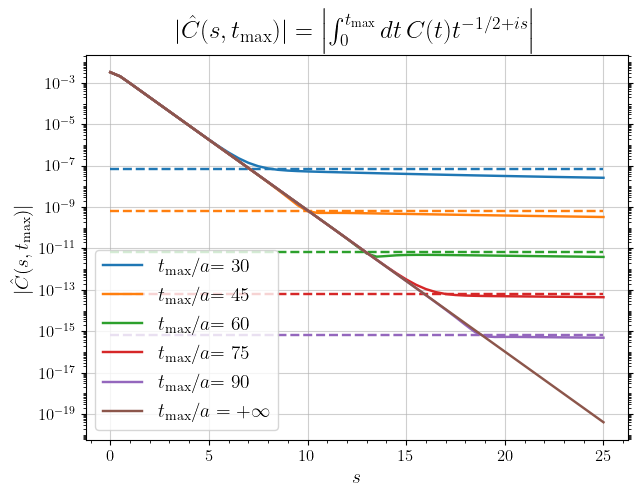

In [2]:
par = np.array([0.001, 0.3])
t_max = [30, 45, 60, 75, 90, +np.inf]
s = np.linspace(0.0001, 25, 51)

for ti in range(len(t_max)):
    y, J = mellin_C2(s, par, 0, t_max[ti])
    mod, _ = modulus(y, J, print_J=True)
    if t_max[ti] == +np.inf:
        line, = plt.plot(s, np.sqrt(2*np.pi)*mod, label = r"$t_\mathrm{max}/a = +\infty$")
    else:
        line, = plt.plot(s, np.sqrt(2*np.pi)*mod, label = r"$t_\mathrm{max}/a$"+r"$={}$".format(t_max[ti]))
    b, _= bound_mellin(t_max[ti], par, 0, 0, print_J=True)
    plt.plot(s, np.sqrt(2*np.pi)*np.full(len(s), b), linestyle='--', color=line.get_color()) 
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$|\hat{C}(s, t_\mathrm{max})|$")
plt.title(r"$|\hat{C}(s, t_\mathrm{max})|=\left\vert\int_0^{t_\mathrm{max}}dt\,C(t)t^{-1/2+is}\right\vert$")
ax = plt.gca()
plt.semilogy()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(LogLocator(10, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=np.arange(10, 100, 10)*0.1,numticks=20))
ax.yaxis.set_minor_formatter(NullFormatter())

[[1.00000000e-03 6.41151980e-15 1.43990865e-18]
 [6.99000000e-03 1.35865623e-14 5.57200458e-18]
 [1.29800000e-02 3.23899091e-14 2.13173128e-17]
 [1.89700000e-02 8.38025837e-14 7.99077733e-17]
 [2.49600000e-02 2.26938952e-13 2.91089951e-16]
 [3.09500000e-02 6.24868381e-13 1.02320815e-15]
 [3.69400000e-02 1.71337173e-12 3.45033588e-15]
 [4.29300000e-02 4.61164070e-12 1.11111082e-14]
 [4.89200000e-02 1.20662748e-11 3.40610679e-14]
 [5.49100000e-02 3.04938919e-11 9.91973623e-14]
 [6.09000000e-02 7.41347369e-11 2.74213908e-13]
 [6.68900000e-02 1.72986988e-10 7.19502401e-13]
 [7.28800000e-02 3.87053155e-10 1.79332589e-12]
 [7.88700000e-02 8.30418557e-10 4.25162699e-12]
 [8.48600000e-02 1.70963462e-09 9.60473464e-12]
 [9.08500000e-02 3.38156415e-09 2.07183022e-11]
 [9.68400000e-02 6.43600601e-09 4.27705670e-11]
 [1.02830000e-01 1.18078433e-08 8.47003793e-11]
 [1.08820000e-01 2.09220519e-08 1.61293370e-10]
 [1.14810000e-01 3.58727204e-08 2.96053576e-10]
 [1.20800000e-01 5.96344739e-08 5.249943

Text(0.5, 1.0, '$\\sigma = 303.5$ $\\mathrm{MeV}$, $t_\\mathrm{max}/a =$$\\,90$, $s_\\mathrm{max} = $$\\,22$')

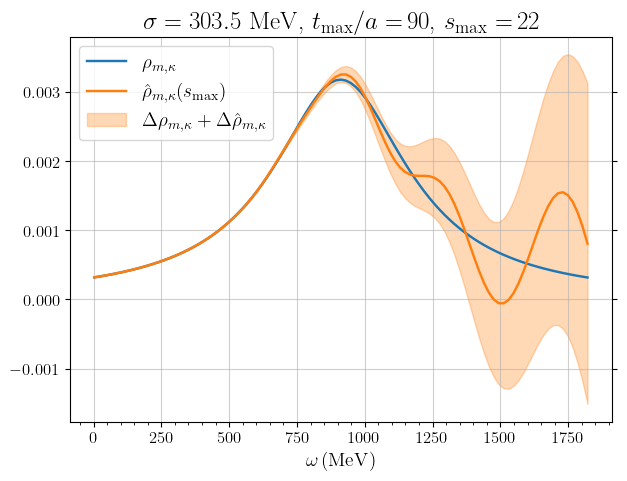

In [27]:
w = np.linspace(0.001, 0.6, 101)
sigma = 0.1
s_max = 22
y_ex = par[0] * sigma/(np.pi*((par[1]-w)**2 + sigma**2))
y, _ = rho_mellin(w, par, s_max, 0, 0, 90, "Breit-Wigner", sigma, print_J=True)
plt.plot(w/(0.065/197.3), y_ex, label = r"$\rho_{m, \kappa}$")
line, = plt.plot(w/(0.065/197.3), y, label = r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")

b_t = np.zeros(len(w))
b_s = np.zeros(len(w))
for wi in range(len(w)):
    b_t[wi], _ = bound_t_rho(w[wi], s_max, 90, 0, [0.001, 0.3, 0, 0], np.diag([0, 0, 0, 0]), "Breit-Wigner", sigma)
    b_s[wi], _ = bound_smax(w[wi], s_max, 0, [0.001, 0.3], np.diag([0, 0]), "Breit-Wigner", sigma, 90)
print(np.c_[w, b_t, b_s])
plt.fill_between(w/(0.065/197.3), y - b_t - np.sqrt(2*np.pi)*b_s, y + b_t + np.sqrt(2*np.pi)*b_s, alpha=0.3, color = line.get_color(), label = r"$\Delta\rho_{m, \kappa} + \Delta\hat{\rho}_{m, \kappa}$")
plt.xlabel(r"$\omega\,(\mathrm{MeV})$")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(250))
ax.xaxis.set_minor_locator(MultipleLocator(50))
#ax.yaxis.set_major_locator(MultipleLocator(0.001))
#ax.yaxis.set_minor_locator(MultipleLocator(0.0002))
#ax.yaxis.set_minor_formatter(NullFormatter())
plt.title(r"$\sigma = {:.1f}$".format(sigma/(0.065/197.3)) + r" $\mathrm{MeV}$, $t_\mathrm{max}/a =$" + r"$\,{}$".format(90) + r", $s_\mathrm{max} = $" + r"$\,{}$".format(s_max))

Text(0.5, 1.0, '$\\sigma = 303.5$ $\\mathrm{MeV}$, $t_\\mathrm{max}/a =$$\\,45$, $s_\\mathrm{max} = $$\\,12$')

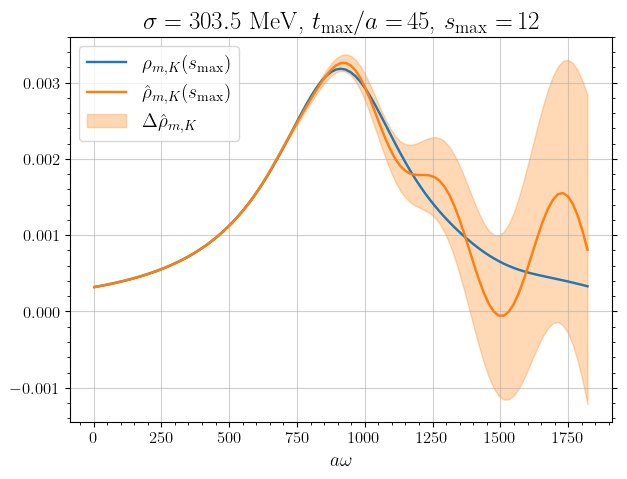

In [20]:
w = np.linspace(0.001, 0.6, 101)
sigma = 0.1
y_ex, _ = rho_mellin(w, par, 22, 0, 0, +np.inf, "Breit-Wigner", sigma, print_J=True)
y, _ = rho_mellin(w, par, 22, 0, 0, 90, "Breit-Wigner", sigma, print_J=True)
plt.plot(w/(0.065/197.3), y_ex, label = r"$\rho_{m, K}(s_\mathrm{max})$")
line, = plt.plot(w/(0.065/197.3), y, label = r"$\hat{\rho}_{m, K}(s_\mathrm{max})$")

b_t = np.zeros(len(w))
#b_s = np.zeros(len(w))
for wi in range(len(w)):
    b_t[wi], _ = bound_t_rho(w[wi], 22, 90, 0, [0.001, 0.3, 0, 0], np.diag([0, 0, 0, 0]), "Breit-Wigner", sigma)
    #b_s[wi], _ = bound_smax(w[wi], 10, 0, [0.001, 0.3], np.diag([0, 0]), "Breit-Wigner", sigma, 90)
plt.fill_between(w/(0.065/197.3), y - b_t, y + b_t, alpha=0.3, color = line.get_color(), label = r"$\Delta\hat{\rho}_{m, K}$")
plt.xlabel(r"$a\omega$")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(250))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(0.001))
ax.yaxis.set_minor_locator(MultipleLocator(0.0002))
ax.yaxis.set_minor_formatter(NullFormatter())
plt.title(r"$\sigma = {:.1f}$".format(sigma/(0.065/197.3)) + r" $\mathrm{MeV}$, $t_\mathrm{max}/a =$" + r"$\,{}$".format(45) + r", $s_\mathrm{max} = $" + r"$\,{}$".format(12))

Text(0.5, 1.0, '$\\rho_{m, K}(s_\\mathrm{max})$ versus $\\hat{\\rho}_{m, K}(s_\\mathrm{max})$')

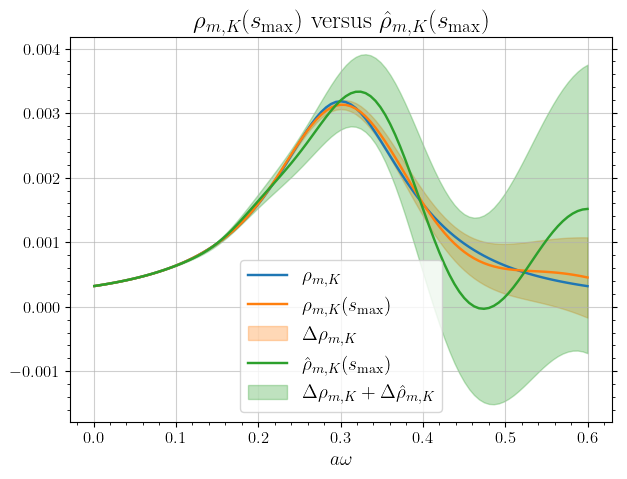

In [5]:
w = np.linspace(0.001, 0.6, 101)
sigma = 0.1
t_max = 45
s_max = 12
y_ex = par[0] * sigma/(np.pi*((par[1]-w)**2 + sigma**2))
y_s, _ = rho_mellin(w, par, s_max, 0, 0, +np.inf, "Breit-Wigner", sigma, print_J=True)
y_st, _ = rho_mellin(w, par, s_max, 0, 0, t_max, "Breit-Wigner", sigma, print_J=True)

b_t = np.zeros(len(w))
b_s_inf = np.zeros(len(w))
b_s = np.zeros(len(w))
for wi in range(len(w)):
    b_t[wi], _ = bound_t_rho(w[wi], s_max, t_max, 0, [0.001, 0.3, 0, 0], np.diag([0, 0, 0, 0]), "Breit-Wigner", sigma)
    b_s_inf[wi], _ = bound_smax(w[wi], s_max, 0, [0.001, 0.3], np.diag([0, 0]), "Breit-Wigner", sigma, +np.inf)
    b_s[wi], _ = bound_smax(w[wi], s_max, 0, [0.001, 0.3], np.diag([0, 0]), "Breit-Wigner", sigma, t_max)
plt.plot(w, y_ex, label = r"$\rho_{m, K}$")
line, = plt.plot(w, y_s, label = r"$\rho_{m, K}(s_\mathrm{max})$")
plt.fill_between(w, y_s - b_s_inf, y_s + b_s_inf, alpha=0.3, color = line.get_color(), label = r"$\Delta\rho_{m, K}$")
line, = plt.plot(w, y_st, label = r"$\hat{\rho}_{m, K}(s_\mathrm{max})$")
plt.fill_between(w, y_st - b_s - b_t, y_st + b_s + b_t, alpha=0.3, color = line.get_color(), label = r"$\Delta\rho_{m, K} + \Delta\hat{\rho}_{m, K}$")
plt.xlabel(r"$a\omega$")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.02))
ax.yaxis.set_major_locator(MultipleLocator(0.001))
ax.yaxis.set_minor_locator(MultipleLocator(0.0002))
ax.yaxis.set_minor_formatter(NullFormatter())
plt.title(r"$\rho_{m, K}(s_\mathrm{max})$ versus $\hat{\rho}_{m, K}(s_\mathrm{max})$")